In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 18})

In [112]:
data = pd.read_csv('train.csv', index_col= 'id')
data.head(3)

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
id,,,,,,,,,,,,,,
0,2014-01-01T00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133
1,2014-01-01T00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468
2,2014-01-01T01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768


Так себя ведёт разница между симуляцией и правильной координатой. Хорошо видно моменты разладки:

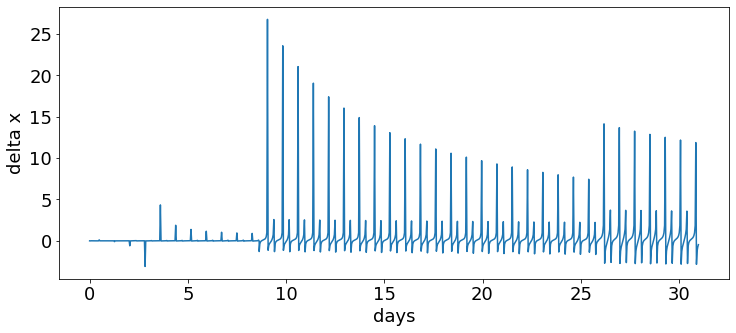

In [218]:
m_id = 0
m_data = data[data.sat_id == m_id].reset_index(drop=True)
plt.figure(figsize=(12, 5))
plt.ylabel('delta x')
plt.xlabel('days')
plt.plot(((pd.to_datetime(m_data['epoch'])- pd.to_datetime(m_data['epoch'])[0])/ np.timedelta64(1, 'D')).astype(float),(m_data['Vx']-m_data['Vx_sim'])/(m_data['Vx']+0.1))

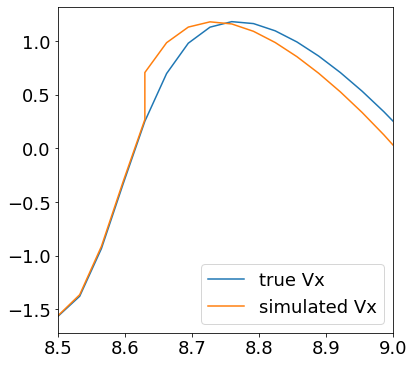

In [219]:
plt.figure(figsize=(6, 6))
plt.plot(((pd.to_datetime(m_data['epoch'])- pd.to_datetime(m_data['epoch'])[0])/ np.timedelta64(1, 'D')).astype(float),m_data['Vx'], label = 'true Vx')
plt.plot(((pd.to_datetime(m_data['epoch'])- pd.to_datetime(m_data['epoch'])[0])/ np.timedelta64(1, 'D')).astype(float),m_data['Vx_sim'], label = 'simulated Vx')

plt.xlim([8.5,9.0])
plt.legend()

In [220]:
m_data['t'] = ((pd.to_datetime(m_data['epoch'])- pd.to_datetime(m_data['epoch'])[0])/ np.timedelta64(1, 'D')).astype(float)

In [221]:
m_data.shape

(958, 15)

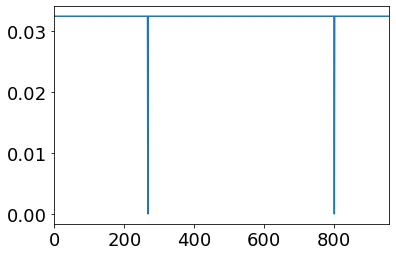

In [222]:
m_data['dt'] = m_data['t'].diff()
m_data['dt'].plot()
# plt.ylim([0.03244212,0.03244215])
# plt.xlim([250,400])

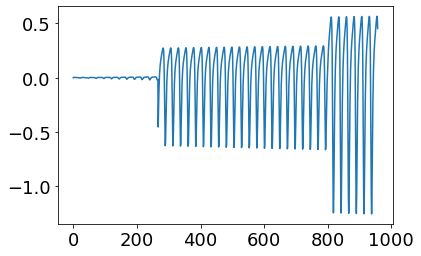

In [223]:
plt.plot((m_data['Vx']-m_data['Vx_sim']))
# # plt.ylim([0.03244212,0.03244215])
# plt.xlim([250,400])

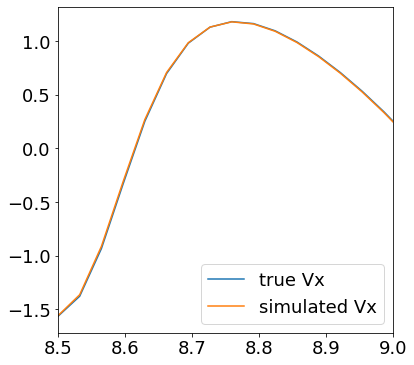

In [224]:
# the most frequent time interval
t_standard = m_data['dt'].value_counts().index[0]

#time steps used for simulations
m_data['t_sim'] = m_data.index.values*t_standard


plt.figure(figsize=(6, 6))
plt.plot(m_data['t'],m_data['Vx'], label = 'true Vx')
plt.plot(m_data['t_sim'],m_data['Vx_sim'], label = 'simulated Vx')

plt.xlim([8.5,9.0])
plt.legend()

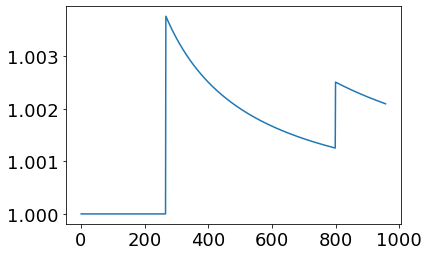

In [225]:
plt.plot(m_data.t_sim/m_data.t)

# Prototype for velocity correction function

Below I consider only Vx case for sat_id = 0. There is a mismatch between the time scale for simulated (with constant time step) and real (varying time step) data. To correct for this discrepancy, we need to map the simulated value to the real time scale. For this, I linearly interpolate the values of Vx_sim at the point of the real value of time. 

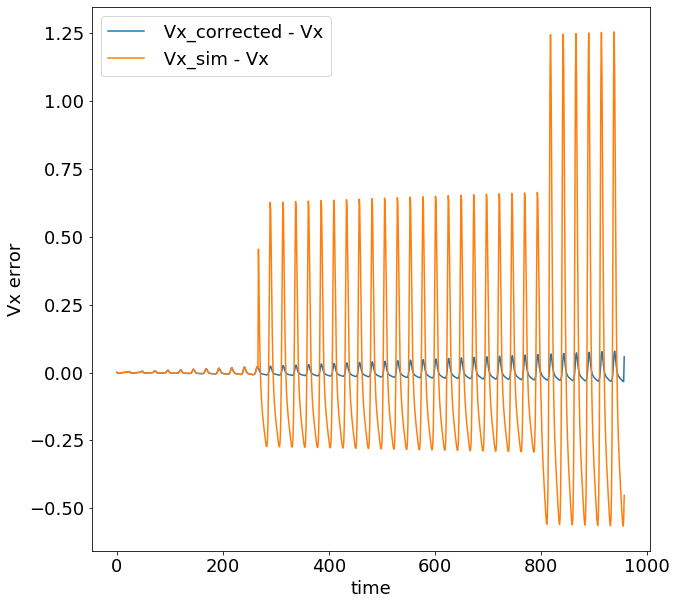

In [226]:
n = m_data.shape[0]
Vx_corrected = [0]*n
Vx_corrected[0] = m_data['Vx_sim'][0]

Vx_sim = m_data['Vx_sim']

for j in range(1,n-1):
    if m_data.t[j] < m_data.t_sim[j]-0.00001:
        # approximate by the left side
        
        # look for the interval
        step = 0
        while m_data.t[j]<m_data.t_sim[j-step]-0.00001:
            step += 1
            
        Vx_corrected[j] = Vx_sim[j-step]-(m_data.t_sim[j-step]-m_data.t[j])/(m_data.t_sim[j-step]-m_data.t_sim[j-step-1])*(Vx_sim[j-step]-Vx_sim[j-step-1])
    elif m_data.t[j] > m_data.t_sim[j]+0.00001:
        # approximate by the right side
        
        # look for the interval
        step = 0
        while m_data.t[j]>m_data.t_sim[j+step]+0.00001:
            step += 1
        
        Vx_corrected[j] = Vx_sim[j+step+1]-(m_data.t_sim[j+step+1]-m_data.t[j])/(m_data.t_sim[j+step+1]-m_data.t_sim[j+step])*(Vx_sim[j+step+1]-Vx_sim[j+step])
    else:
        Vx_corrected[j] = Vx_sim[j]

Vx_corrected[n-1] = Vx_sim[n-1] + Vx_corrected[n-2]- Vx_sim[n-2]

plt.figure(figsize=(10, 10))
plt.plot(Vx_corrected- m_data['Vx'], label = ' Vx_corrected - Vx')
plt.plot(Vx_sim-m_data['Vx'], label = ' Vx_sim - Vx')
# plt.plot(m_data['Vx'])
# plt.xlim([900,1000])
plt.xlabel('time')
plt.ylabel('Vx error')
plt.legend()

   
        
    


Correction helps!!! But it does not remove all the error. Let's look at another example.

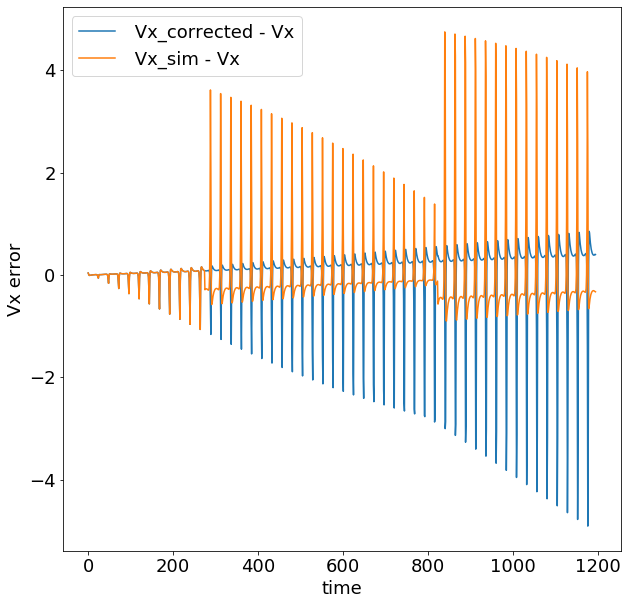

In [285]:
m_id = 50
m_data = data[data.sat_id == m_id].reset_index(drop=True)
m_data['t'] = ((pd.to_datetime(m_data['epoch'])- pd.to_datetime(m_data['epoch'])[0])/ np.timedelta64(1, 'D')).astype(float)
m_data['dt'] = m_data['t'].diff()
# the most frequent time interval
t_standard = m_data['dt'].value_counts().index[0]

#time steps used for simulations
m_data['t_sim'] = m_data.index.values*t_standard

n = m_data.shape[0]
Vx_corrected = [0]*n
Vx_corrected[0] = m_data['Vx_sim'][0]

Vx_sim = m_data['Vx_sim']

for j in range(1,n-1):
    if m_data.t[j] < m_data.t_sim[j]-0.00001:
        # approximate by the left side
        
        # look for the interval
        step = 0
        while m_data.t[j]<m_data.t_sim[j-step]-0.00001:
            step += 1
#             print(step)
        Vx_corrected[j] = Vx_sim[j-step]-(m_data.t_sim[j-step]-m_data.t[j])/(m_data.t_sim[j-step]-m_data.t_sim[j-step-1])*(Vx_sim[j-step]-Vx_sim[j-step-1])
    elif m_data.t[j] > m_data.t_sim[j]+0.00001:
        # approximate by the right side
        
        # look for the interval
        step = 0
        while m_data.t[j]>m_data.t_sim[j+step]+0.00001:
            step += 1
        
        Vx_corrected[j] = Vx_sim[j+step+1]-(m_data.t_sim[j+step+1]-m_data.t[j])/(m_data.t_sim[j+step+1]-m_data.t_sim[j+step])*(Vx_sim[j+step+1]-Vx_sim[j+step])
    else:
        Vx_corrected[j] = Vx_sim[j]

Vx_corrected[n-1] = Vx_sim[n-1] + Vx_corrected[n-2]- Vx_sim[n-2]

plt.figure(figsize=(10, 10))
plt.plot(Vx_corrected- m_data['Vx'], label = ' Vx_corrected - Vx')
plt.plot(Vx_sim-m_data['Vx'], label = ' Vx_sim - Vx')
# plt.plot(m_data['Vx'])
# plt.xlim([900,1000])
plt.xlabel('time')
plt.ylabel('Vx error')
plt.legend()

(950, 1000)

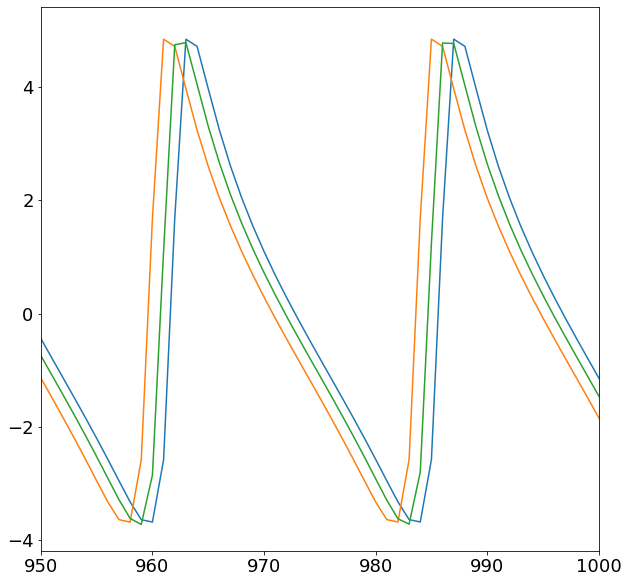

In [260]:
plt.figure(figsize=(10, 10))
plt.plot(Vx_corrected)
plt.plot(Vx_sim, label = ' Vx_sim - Vx')
plt.plot(m_data['Vx'])
plt.xlim([950,1000])

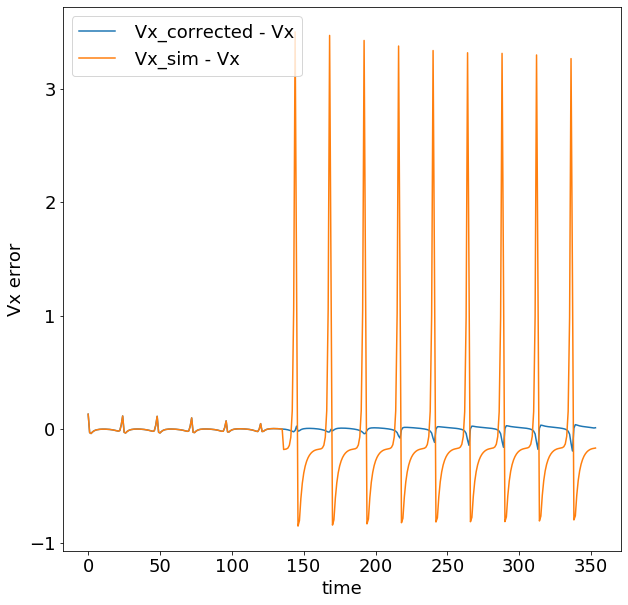

In [278]:
m_id = 3
m_data = data[data.sat_id == m_id].reset_index(drop=True)
m_data['t'] = ((pd.to_datetime(m_data['epoch'])- pd.to_datetime(m_data['epoch'])[0])/ np.timedelta64(1, 'D')).astype(float)
m_data['dt'] = m_data['t'].diff()
# the most frequent time interval
t_standard = m_data['dt'].value_counts().index[0]

#time steps used for simulations
m_data['t_sim'] = m_data.index.values*t_standard

n = m_data.shape[0]
Vx_corrected = [0]*n
Vx_corrected[0] = m_data['Vx_sim'][0]

Vx_sim = m_data['Vx_sim']

for j in range(1,n-1):
    if m_data.t[j] < m_data.t_sim[j]-0.00001:
        # approximate by the left side
        
        # look for the interval
        step = 0
        while m_data.t[j]<m_data.t_sim[j-step]-0.00001:
            step += 1
#             print(step)
        Vx_corrected[j] = Vx_sim[j-step]-(m_data.t_sim[j-step]-m_data.t[j])/(m_data.t_sim[j-step]-m_data.t_sim[j-step-1])*(Vx_sim[j-step]-Vx_sim[j-step-1])
    elif m_data.t[j] > m_data.t_sim[j]+0.00001:
        # approximate by the right side
        
        # look for the interval
        step = 0
        while m_data.t[j]>m_data.t_sim[j+step]+0.00001:
            step += 1
        
        Vx_corrected[j] = Vx_sim[j+step+1]-(m_data.t_sim[j+step+1]-m_data.t[j])/(m_data.t_sim[j+step+1]-m_data.t_sim[j+step])*(Vx_sim[j+step+1]-Vx_sim[j+step])
    else:
        Vx_corrected[j] = Vx_sim[j]

Vx_corrected[n-1] = Vx_sim[n-1] + Vx_corrected[n-2]- Vx_sim[n-2]

plt.figure(figsize=(10, 10))
plt.plot(Vx_corrected- m_data['Vx'], label = ' Vx_corrected - Vx')
plt.plot(Vx_sim-m_data['Vx'], label = ' Vx_sim - Vx')
# plt.plot(m_data['Vx'])
# plt.xlim([900,1000])
plt.xlabel('time')
plt.ylabel('Vx error')
plt.legend()